In [24]:
import numpy as np
from scipy.io import netcdf as nc
from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.basemap import Basemap, cm, shiftgrid, maskoceans
from matplotlib import colors
import numpy.ma as ma
from scipy.interpolate import griddata
import copy

In [25]:
nlon = 180
nlat = 90
grid_area = np.ones((nlat, nlon))*-9999.
earth_area =  5.096e14;
lat = np.arange(-89, 91, 2)
res = 2;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

## Examine litter input and output in FATES

In [72]:
############################################################
### Diagnosis of transient case
############################################################

## Inputs from user
## Some constants
yr_beg = 1880
nyr = 130

##  get and open the history file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
filename_in = 'sshu.cori-haswell.E4f9ce69d2-Faaa10622.2022-03-20.elm.h0.spinup.nc'

## Do not modify the following
## Spinup history
# Monthly mean output
fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years

## define the sizes of each dimension
ntim = len(time)

## read in variables
lit_in = fin.variables['FATES_LITTER_IN'][:]
lit_out = fin.variables['FATES_LITTER_OUT'][:]
fates_hr = fin.variables['FATES_HET_RESP'][:]
soilc = fin.variables['SOILC'][:]
fates_nep = fin.variables['FATES_NEP'][:]
fates_gpp = fin.variables['FATES_GPP'][:]
fates_npp = fin.variables['FATES_NPP'][:]
fates_ar = fin.variables['FATES_AUTORESP'][:]
vegc = fin.variables['FATES_VEGC'][:]

fin.close()

# Auxiliary data: land use time series
## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
lu_hrv_frac_vh1 = fin_luinput2.variables['HARVEST_VH1_FRAC'][:]
lu_hrv_frac_vh2 = fin_luinput2.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_frac_sh1 = fin_luinput2.variables['HARVEST_SH1_FRAC'][:]
lu_hrv_frac_sh2 = fin_luinput2.variables['HARVEST_SH2_FRAC'][:]
lu_hrv_frac_sh3 = fin_luinput2.variables['HARVEST_SH3_FRAC'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
lat_4x5 = latnc
lon_4x5 = lonnc


In [73]:
# Calculate global total
# Check one slice of the time series 
# apply land mask
lit_in_copy = copy.deepcopy(lit_in[1560,:,:])
lit_in_copy[land_4x5<=0] = np.float('nan')
lit_in_copy[lit_in_copy>1] = np.float('nan')
lit_out_copy = copy.deepcopy(lit_out[1560,:,:])
lit_out_copy[land_4x5<=0] = np.float('nan')
lit_out_copy[lit_out_copy>1] = np.float('nan')
fates_hr_copy = copy.deepcopy(fates_hr[1560,:,:])
fates_hr_copy[land_4x5<=0] = np.float('nan')
fates_hr_copy[fates_hr_copy>1] = np.float('nan')

soilc_copy = copy.deepcopy(soilc[1560,:,:])
soilc_copy[land_4x5<=0] = np.float('nan')
soilc_copy[soilc_copy>1e7] = np.float('nan')

tot_lit_in = np.nansum(np.nansum(lit_in_copy[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
tot_lit_out = np.nansum(np.nansum(lit_out_copy[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
tot_fates_hr = np.nansum(np.nansum(fates_hr_copy[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
tot_soilc = np.nansum(np.nansum(soilc_copy[:,:]*area_4x5, 0), 0)*1e6/1e15


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


In [78]:
# Calculate global total
# Check the whole time series 

lit_in_copy = copy.deepcopy(lit_in[:,:,:])
lit_out_copy = copy.deepcopy(lit_out[:,:,:])
fates_hr_copy = copy.deepcopy(fates_hr[:,:,:])
fates_npp_copy = copy.deepcopy(fates_npp[:,:,:])
soilc_copy = copy.deepcopy(soilc[:,:,:])
vegc_copy = copy.deepcopy(vegc[:,:,:])

tot_len = nyr * 12
tot_lit_in = np.zeros((tot_len))
tot_lit_out = np.zeros((tot_len))
tot_fates_hr = np.zeros((tot_len))
tot_fates_npp = np.zeros((tot_len))
tot_soilc = np.zeros((tot_len))
tot_vegc = np.zeros((tot_len))

for i in np.arange(0, tot_len):
    # Mask can only applied to each 2D slice
    tmp = lit_in_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1] = np.float('nan')
    tot_lit_in[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = lit_out_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1] = np.float('nan')
    tot_lit_out[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = fates_hr_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1] = np.float('nan')    
    tot_fates_hr[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12
    
    tmp = soilc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e7] = np.float('nan')    
    tot_soilc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15
    
    tmp = vegc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e7] = np.float('nan')    
    tot_vegc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = fates_npp_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1] = np.float('nan')    
    tot_fates_npp[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6*3600*24*365/1e12

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


Text(0,0.5,'C Fluxes (PgC yr-1)')

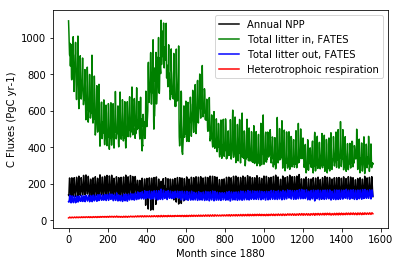

In [65]:
plt.plot(tot_fates_npp, 'k-')
plt.plot(tot_lit_in, 'g-')
plt.plot(tot_lit_out, 'b-')
plt.plot(tot_fates_hr, 'r-')
plt.legend(['Annual NPP', 'Total litter in, FATES','Total litter out, FATES', 'Heterotrophoic respiration'])
plt.xlabel('Month since 1880')
plt.ylabel('C Fluxes (PgC yr-1)')

Text(0,0.5,'C Fluxes (PgC yr-1)')

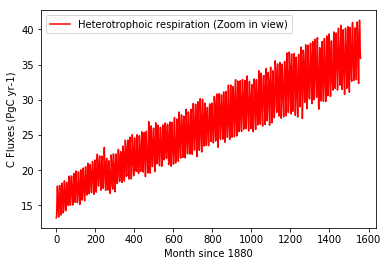

In [66]:
plt.plot(tot_fates_hr, 'r-')
plt.legend(['Heterotrophoic respiration (Zoom in view)'])
plt.xlabel('Month since 1880')
plt.ylabel('C Fluxes (PgC yr-1)')

Text(0,0.5,'C Pools (PgC )')

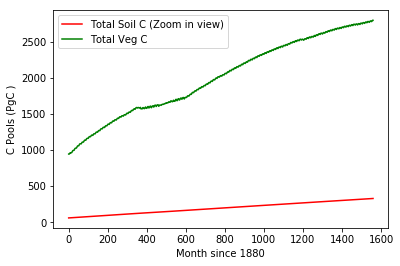

In [79]:
plt.plot(tot_soilc, 'r-')
plt.plot(tot_vegc, 'g-')
plt.legend(['Total Soil C (Zoom in view)', 'Total Veg C'])
plt.xlabel('Month since 1880')
plt.ylabel('C Pools (PgC )')

Text(0,0.5,'C Pools (PgC )')

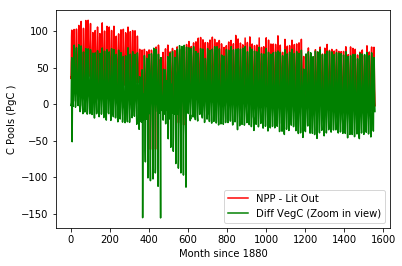

In [81]:
veg_old = tot_vegc[0:tot_len-1]
veg_new = tot_vegc[1:tot_len]
diff_veg = veg_new - veg_old
plt.plot(tot_fates_npp-tot_lit_out, 'r-')
plt.plot(diff_veg*12, 'g-')
plt.legend(['NPP - Lit Out', 'Diff VegC'])
plt.xlabel('Month since 1880')
plt.ylabel('C Pools (PgC )')